# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [71]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [72]:
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [73]:
def plot_decisions(X, y, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [74]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_errors = 1- train_scores
    test_errors = 1-test_scores
    
    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")

    
    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [75]:
class MLPWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10):
        self.layer1 = layer1
        self.layer2 = layer2

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 1000,
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [76]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=100,
)

In [77]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=100,
)

# Solutions

## Task 1

Load dataset_1_train.csv file

In [45]:
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [32]:
data = np.loadtxt("dataset_1_train.csv", delimiter=",")

In [33]:
X = data[:,:2]
y = data[:,2:]

### Plotting X,y using SVC for different values of C (Regularization)

Plot for C =  0.001


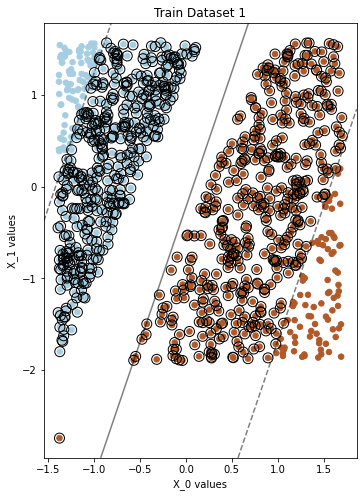

Accuracy score= 0.998001998001998


Plot for C =  0.01


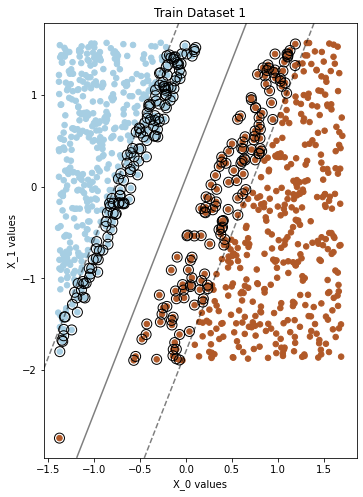

Accuracy score= 0.999000999000999


Plot for C =  0.1


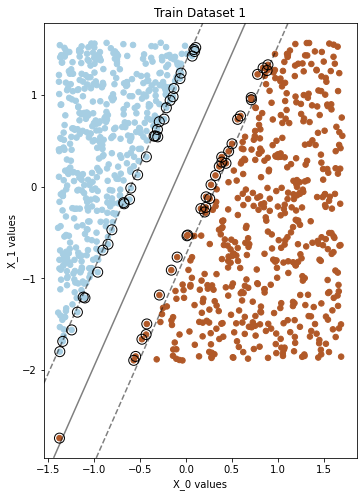

Accuracy score= 0.999000999000999


Plot for C =  1


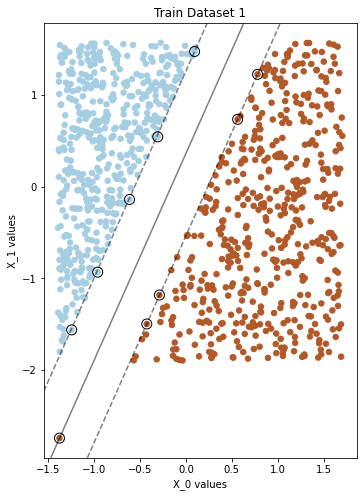

Accuracy score= 0.999000999000999


Plot for C =  5


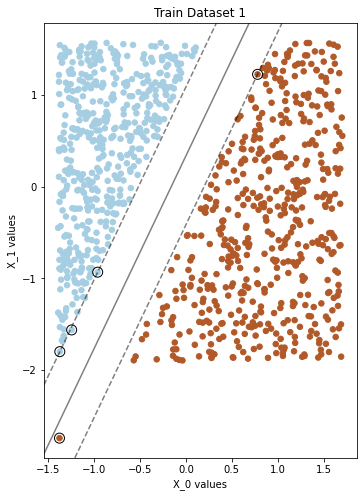

Accuracy score= 1.0


Plot for C =  6


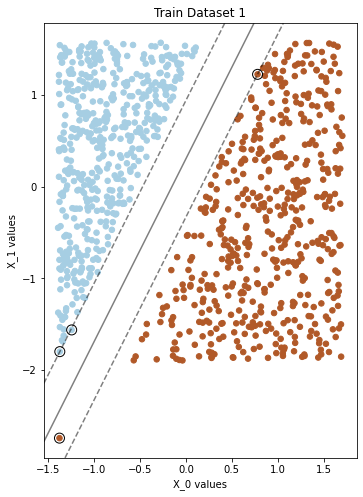

Accuracy score= 1.0


Plot for C =  7


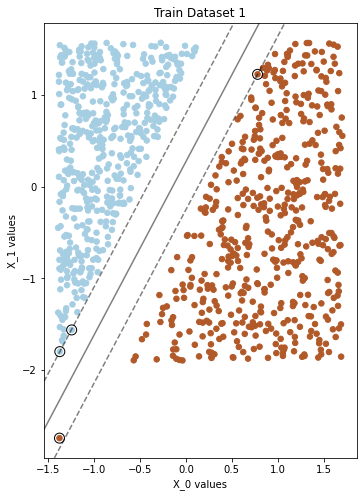

Accuracy score= 1.0


Plot for C =  7.5


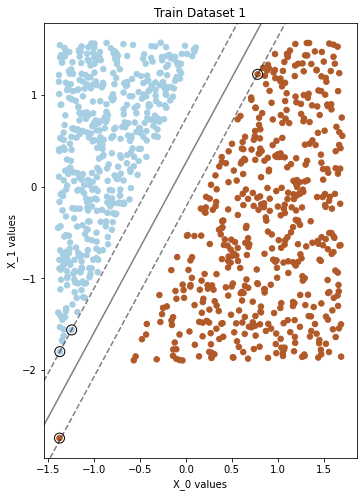

Accuracy score= 1.0


Plot for C =  10


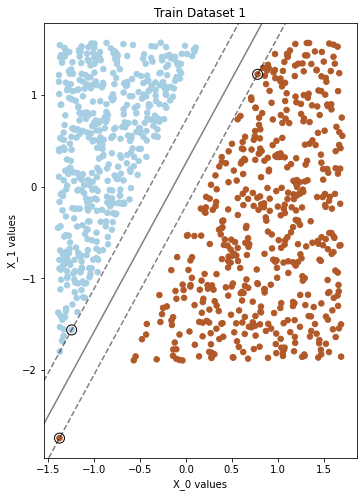

Accuracy score= 1.0


Plot for C =  100


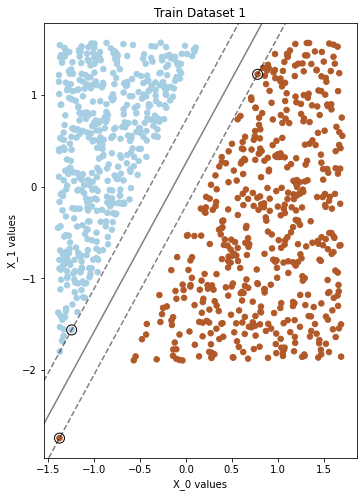

Accuracy score= 1.0


Plot for C =  1000


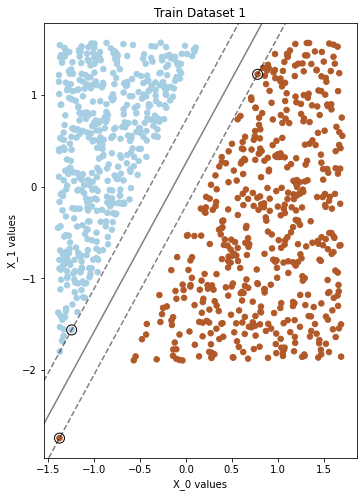

Accuracy score= 1.0




In [12]:
C_vals = [0.001,0.01,0.1,1,5,6,7,7.5,10,100,1000]
for c in C_vals:
    print("Plot for C = ",c)
    plt.figure(figsize=(10, 8))
    clf = svm.SVC(C=c, kernel = 'linear',gamma = 'auto')
    clf.fit(X,y.ravel())
    plt.title("Train Dataset 1")
    plt.xlabel("X_0 values")
    plt.ylabel("X_1 values")
    plot_margin(X,y,clf)
    plt.show()
    
    y_pred= clf.predict(X) 
    # Model Accuracy
    accuracy = accuracy_score(y, y_pred)
    print ('Accuracy score= {}'.format(accuracy))
    print()
    print("="*50)
    print()

I took inspiration from my peers and got to know that with C = 7.5 I get a better classification as all the data-set are correctly classified.

 ### Using BayesSearchCV optimizer to find the best hyperparameters

In [37]:
optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=50,
    random_state=42
)
optSVM1_lin.fit(X, y.ravel())

BayesSearchCV(estimator=SVC(), random_state=42,
              search_spaces={'C': Real(low=0.001, high=1000.0, prior='log-uniform', transform='normalize'),
                             'kernel': Categorical(categories=('linear',), prior=None)})

In [40]:
print("Score: ", optSVM1_lin.score(X, y))
print("Best Estimator: ", optSVM1_lin.best_estimator_)

Score:  1.0
Best Estimator:  SVC(C=0.46665408703686484, kernel='linear')


Plot for C = 0.46665408703686484


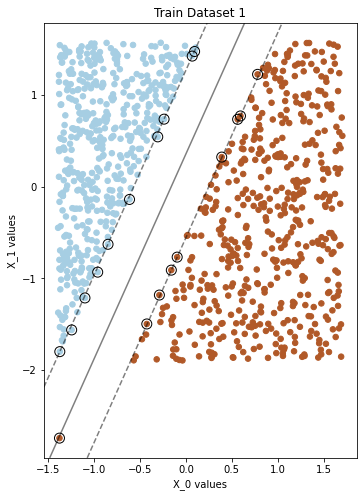

Accuracy score= 1.0




In [41]:
# Using above C value we will now use SVC to plot the data
print("Plot for C = 0.46665408703686484")
plt.figure(figsize=(10, 8))
clf = svm.SVC(C=0.46665408703686484, kernel = 'linear',gamma = 'auto')
clf.fit(X,y.ravel())
plt.title("Train Dataset 1")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
plot_margin(X,y,clf)
plt.show()
    
y_pred= clf.predict(X) 
# Model Accuracy
accuracy = accuracy_score(y, y_pred)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

 ### Using GridSearchCV optimizer to find the best hyperparameters

In [15]:
param_grid_1 = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']}
 
grid_1 = GridSearchCV(svm.SVC(), param_grid_1, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_1.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV 1/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 2/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 3/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 4/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 5/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 1/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV 2/5] END ...............C=0.1, gamma=0.01, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']},
             verbose=3)

In [16]:
# print best parameter after tuning
print(grid_1.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid_1.best_estimator_)

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=0.1, gamma=1, kernel='linear')


Plot for C = 0.1


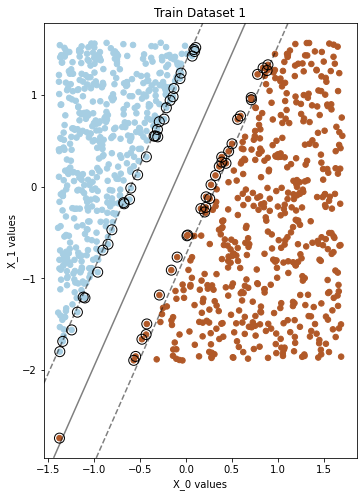

Accuracy score= 0.999000999000999




In [42]:
# Using above C value we will now use SVC to plot the data
print("Plot for C = 0.1")
plt.figure(figsize=(10, 8))
clf = svm.SVC(C=0.1, kernel = 'linear',gamma=1)
clf.fit(X,y.ravel())
plt.title("Train Dataset 1")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
plot_margin(X,y,clf)
plt.show()
    
y_pred= clf.predict(X) 
# Model Accuracy
accuracy = accuracy_score(y, y_pred)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

## Reflection

The hyperparameter C determines the trade-off between margin maximization and misclassification minimization.
When C is small, classification mistakes are less of a concern, and the focus is on increasing the margin; conversely, when C is big, the focus is on preventing misclassification at the expense of maintaining a modest margin. The softer the margin, the lower the C parameter. We can observe that the categorization is poor and they breach the soft margin when C is between 0.0001 and 0.1. We find better classification as the C parameter is increased. The greater the margin, the better the model's generalization ability. We can observe one outlier point at C=1 that is on the margin and is accurately identified.

Later we use BayesSearchCV to find the optimum C value and we observe that we get C = 0.4666 and plot the graph using SVC with the this optimum C value and we are able to achieve a decent classification, however we still see 1 data-point over the hard-margin.

Finally I also tried GridSearchCV for finding the optimum parameter which suggested C = 0.1 and gamma = 1 but that was not very usefull as we could see many data-points are inside the margin with just 1 data-point miss-classified, also accuracy is decreased.

Hence we can conclude from above plots that with regularization C = 7.5 trained model is a hard marging and for C = 0.4666 we get a soft-margin.

In most cases, we don't have a linearly separable dataset with which to define the hard-margin. The goal is to maximize margin while ensuring that the model has the least amount of misclassification possible, which we can accomplish using soft-margin.
As a result, we can say that when there is a trade-off between maximum margin-width and least misclassification, the model will be more generalize.

# Task 2

## Using Dataset 2

Load dataset_2_train.csv and dataset_2_test.csv files

In [78]:
train_data = np.loadtxt("dataset_2_train.csv", delimiter=",")
test_data = np.loadtxt("dataset_2_test.csv", delimiter=",")

In [79]:
# Create X_train, X_test, y_train and y_train

X_train_2 = train_data[:,:2]
X_test_2 = test_data[:,:2]
y_train_2 = train_data[:,2:]
y_test_2 = test_data[:,2:]

In [80]:
# Print shape of each data
print(f'X_train shape: {X_train_2.shape}')
print(f'y_train shape: {y_train_2.shape}')
print(f'X_test shape {X_test_2.shape}')
print(f'y_test shape {y_test_2.shape}')

X_train shape: (670, 2)
y_train shape: (670, 1)
X_test shape (331, 2)
y_test shape (331, 1)


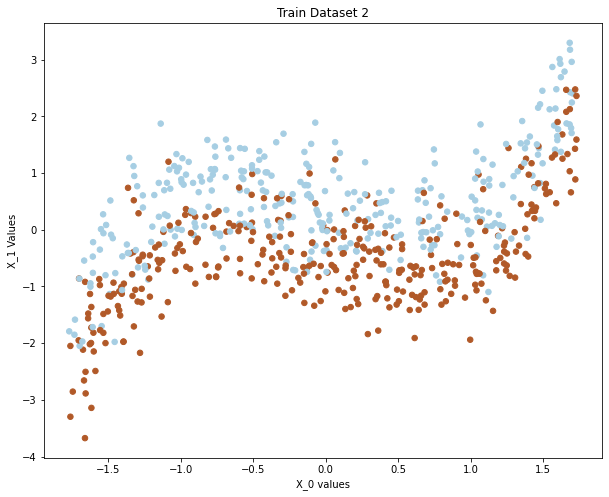

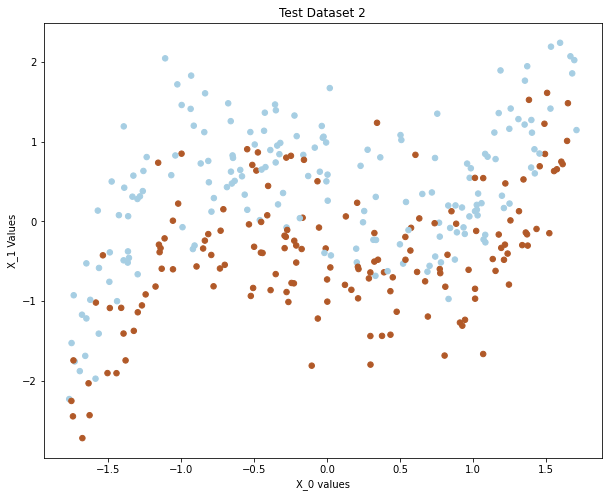

In [81]:
# Plotting the train data-set
plt.figure(figsize=(10, 8))
plt.scatter(X_train_2[:,0], X_train_2[:,1], c=y_train_2, s=30, cmap=plt.cm.Paired)
plt.title("Train Dataset 2")
plt.xlabel("X_0 values")
plt.ylabel("X_1 Values")
plt.show()

# Plotting the train data-set
plt.figure(figsize=(10, 8))
plt.scatter(X_test_2[:,0], X_test_2[:,1], c=y_test_2, s=30, cmap=plt.cm.Paired)
plt.title("Test Dataset 2")
plt.xlabel("X_0 values")
plt.ylabel("X_1 Values")
plt.show()

### Implementing SVM with different Kernels keeping C = 1 and gamma = auto

### Using Linear Kernel

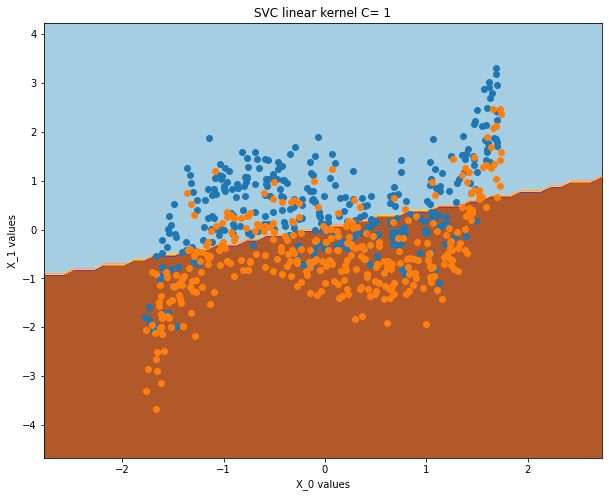

Accuracy score= 0.6888217522658611




In [82]:
clf_2 = svm.SVC(C=1, kernel = 'linear',gamma = 'auto')
clf_2.fit(X_train_2,y_train_2.ravel())
plt.figure(figsize=(10, 8))
plt.title("SVC linear kernel C= 1")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
#plot_margin(X_train,y_train.ravel(),clf_2)
plot_decisions(X_train_2,y_train_2.ravel(),clf_2)
plt.show()
    
y_pred_2 = clf_2.predict(X_test) 
# Model Accuracy
accuracy = accuracy_score(y_test_2, y_pred_2)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

### Using Sigmoid Kernel

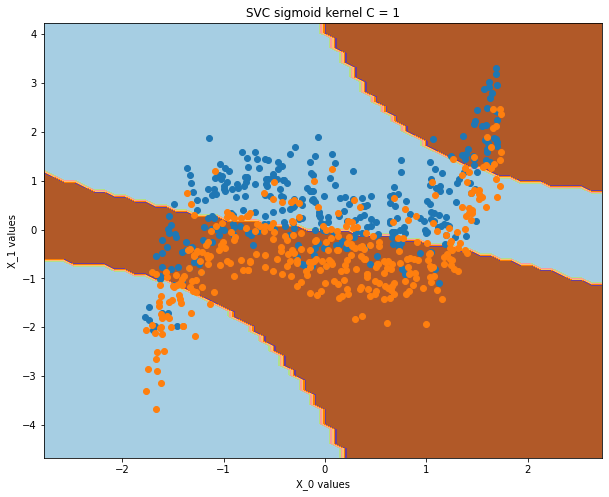

Accuracy score= 0.6737160120845922




In [26]:

clf_2 = svm.SVC(C=1, kernel = 'sigmoid', gamma = 'auto')
clf_2.fit(X_train_2,y_train_2.ravel())
plt.figure(figsize=(10, 8))
plt.title("SVC sigmoid kernel C = 1")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
#plot_margin(X_train,y_train.ravel(),clf_2)
plot_decisions(X_train_2,y_train_2.ravel(),clf_2)
plt.show()
    
y_pred_2 = clf_2.predict(X_test) 
# Model Accuracy
accuracy = accuracy_score(y_test_2, y_pred_2)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

### Using RBF kernel

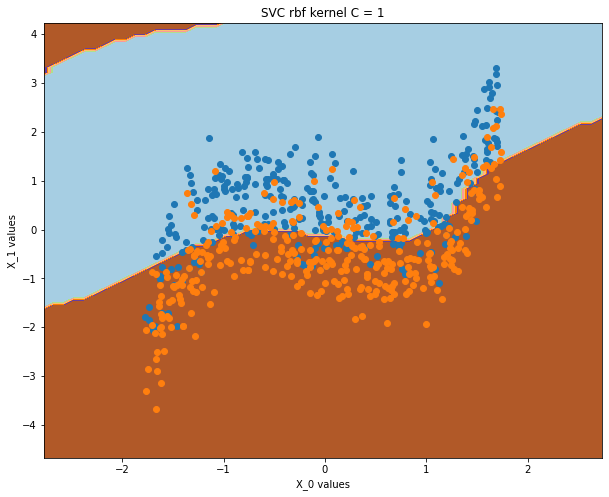

Accuracy score= 0.7462235649546828




In [27]:

clf_2 = svm.SVC(C=1, kernel = 'rbf', gamma = 'auto')
clf_2.fit(X_train_2,y_train_2.ravel())
plt.figure(figsize=(10, 8))
plt.title("SVC rbf kernel C = 1")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
#plot_margin(X_train,y_train.ravel(),clf_2)
plot_decisions(X_train_2,y_train_2.ravel(),clf_2)
plt.show()
    
y_pred_2 = clf_2.predict(X_test) 
# Model Accuracy
accuracy = accuracy_score(y_test_2, y_pred_2)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

### Using Polynomial Kernel

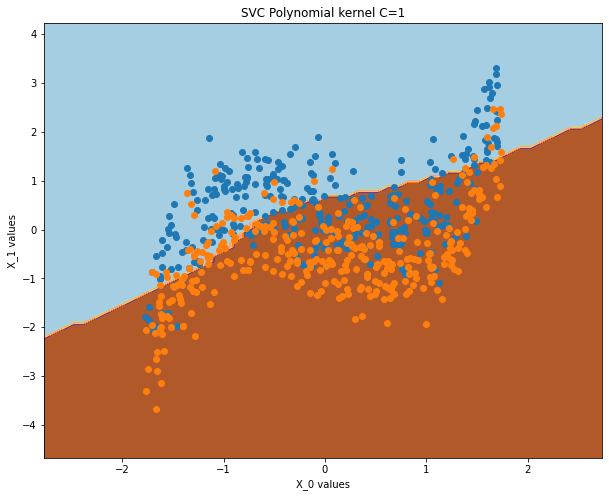

Accuracy score= 0.6858006042296072




In [28]:
clf_2 = svm.SVC(C=1, kernel = 'poly', gamma = 'auto')
clf_2.fit(X_train_2,y_train_2.ravel())
plt.figure(figsize=(10, 8))
plt.title("SVC Polynomial kernel C=1")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
#plot_margin(X_train,y_train.ravel(),clf_2)
plot_decisions(X_train_2,y_train_2.ravel(),clf_2)

plt.show()
    
y_pred_2 = clf_2.predict(X_test) 
# Model Accuracy
accuracy = accuracy_score(y_test_2, y_pred_2)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

From the above plots we can infer that rbf kernel yields the best accuracy score (~ 75%) with a constant C value, now we need to find an optimized value for C and gamma which we will try to find using Bayesian Search CV 

### Using BayesSearchCV optimizer to find the best hyperparameters for data-set 2

In [88]:
optSVM1_data_2 = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 100.0, prior='log-uniform'),
      'gamma' : (1e-3, 100.0, prior='log-uniform'),
      'kernel': Categorical(['linear', 'poly', 'sigmoid', 'rbf']), 
    },
    n_iter=50,
    random_state=42
)

optSVM1_data_2.fit(X_train_2, y_train_2.ravel())

BayesSearchCV(estimator=SVC(), random_state=42,
              search_spaces={'C': Real(low=0.001, high=100.0, prior='log-uniform', transform='normalize'),
                             'gamma': (0.001, 100.0, 'log-uniform'),
                             'kernel': Categorical(categories=('linear', 'poly', 'sigmoid', 'rbf'), prior=None)})

In [89]:
print("Best Kernel: ",optSVM1_data_2.best_estimator_.kernel)
print("Best Estimator: ",optSVM1_data_2.best_estimator_)

Best Kernel:  rbf
Best Estimator:  SVC(C=28.31827998811012, gamma=0.10580821133641592)


Using optiml paramters from Bayes Search CV for SVC to plot on the dataset-2

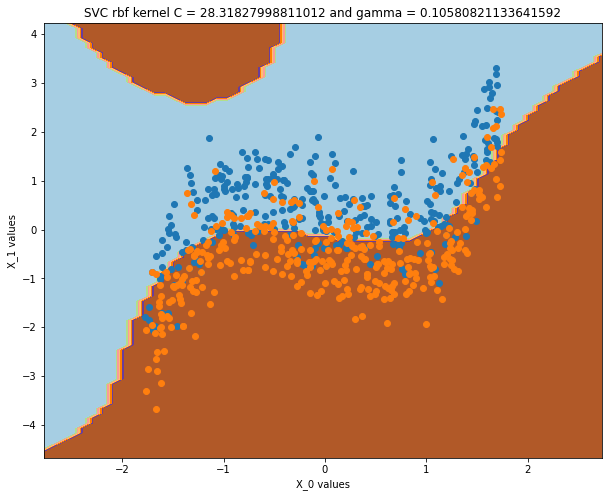

Accuracy score= 0.7583081570996979




In [90]:
clf_2 = svm.SVC(C=28.31827998811012, kernel = 'rbf', gamma = 0.10580821133641592)
clf_2.fit(X_train_2,y_train_2.ravel())
plt.figure(figsize=(10, 8))
plt.title("SVC rbf kernel C = 28.31827998811012 and gamma = 0.10580821133641592")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
#plot_margin(X_train,y_train.ravel(),clf_2)
plot_decisions(X_train_2,y_train_2.ravel(),clf_2)
plt.show()
    
y_pred_2 = clf_2.predict(X_test_2) 
# Model Accuracy
accuracy = accuracy_score(y_test_2, y_pred_2)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

In [91]:
print("Training Accuracy:", clf_2.score(X_train_2, y_train_2))
print("Test Accuracy:", clf_2.score(X_test_2, y_test_2))

Training Accuracy: 0.7805970149253731
Test Accuracy: 0.7583081570996979


Here from above calculation we saw that using BaysianSearchCV we got optimized parameters for C, gamma and kernel which we used to further train the model and we could see we were able to achieve better results.

<module 'matplotlib.pyplot' from 'C:\\Users\\jdsam\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

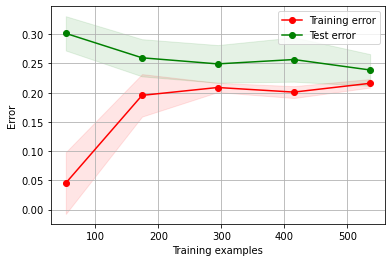

In [86]:
plot_learning_curve(optSVM1_data_2,"Training SVM",X_train_2,y_train_2)

### Using BayesSearchCV with the MLPWrapper on data-set 2

In [99]:
optNN1_2 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=30,
    random_state=42
)

In [100]:
optNN1_2.fit(X_train_2,y_train_2.ravel())

BayesSearchCV(estimator=MLPWrapper(), n_iter=30, random_state=42,
              search_spaces={'layer1': Integer(low=1, high=100, prior='uniform', transform='normalize'),
                             'layer2': Integer(low=1, high=100, prior='uniform', transform='normalize')})

In [101]:
print("Score: ",optNN1_2.score(X_test_2, y_test_2))
print("Best paramter: ",optNN1_2.best_estimator_)

Score:  0.7885196374622356
Best paramter:  MLPWrapper(layer1=40, layer2=50)


In [132]:
# Train MLP wrapper using the optimal layers received from BaysianSearchCV MLP wrapper
mlp_clf_2 = MLPClassifier(random_state=42,hidden_layer_sizes=(40,50),
                         activation = 'relu', solver='adam').fit(X_train_2, y_train_2)
print("Score: ",mlp_clf_2.score(X_test_2, y_test_2))

Score:  0.7643504531722054


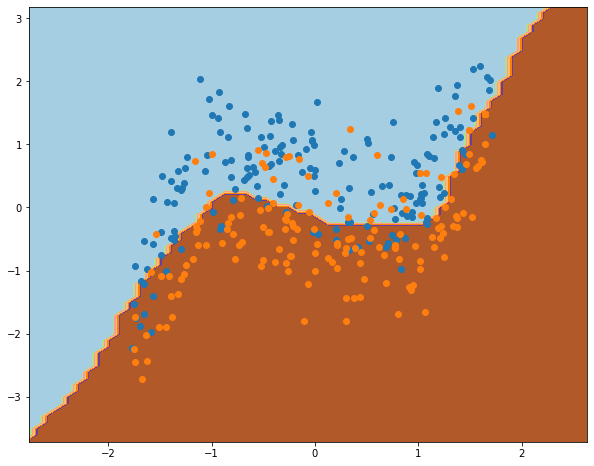

In [106]:
# Plotting decision boundary
plt.figure(figsize=(10, 8))
plot_decisions(X_test_2,y_test_2,optNN1_2)


In [107]:
print("Training Accuracy:", optNN1_2.score(X_train_2, y_train_2))
print("Test Accuracy:",optNN1_2.score(X_test_2, y_test_2))

Training Accuracy: 0.7791044776119403
Test Accuracy: 0.7885196374622356


Here we can see that using MLP (Neural network) search we were able to further tune the hyper-paramaetrs and achieve an overall test accuracy of about 78.85 %

<module 'matplotlib.pyplot' from 'C:\\Users\\jdsam\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

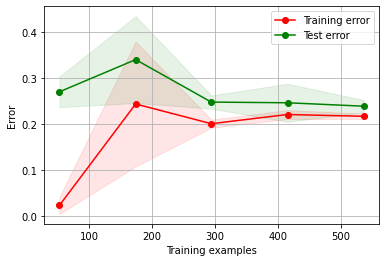

In [58]:
# Plotting the learning curve
plot_learning_curve(optNN1_2,"Training SVM",X_train_2,y_train_2)

### Using GridSearchCV on data-set 2

In [149]:
param_grid_2 = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf']}
 
grid_2 = GridSearchCV(svm.SVC(), param_grid_2, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_2.fit(X_train_2, y_train_2.ravel())

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 2/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 3/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 4/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 5/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 1/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 2/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 4/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 5/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV 2/5] END ...................C=0.001, gamma=

[CV 3/5] END ..................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 4/5] END ..................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/5] END ..................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/5] END ..............C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV 2/5] END ..............C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV 3/5] END ..............C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV 4/5] END ..............C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV 5/5] END ..............C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV 1/5] END ................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV 2/5] END ................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV 3/5] END ................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV 4/5] END ................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV 5/5] END ...............

[CV 3/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV 1/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV 2/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV 3/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV 4/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV 5/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.0s
[CV 1/5] END ...............C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV 2/5] END ...............C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV 3/5] END ...............C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV 4/5] END ...............C=0.1, gamma=0.0001, kernel=poly; total time=   0.0s
[CV 5/5] END ...............

[CV 1/5] END .................C=10, gamma=0.1, kernel=linear; total time=   0.0s
[CV 2/5] END .................C=10, gamma=0.1, kernel=linear; total time=   0.0s
[CV 3/5] END .................C=10, gamma=0.1, kernel=linear; total time=   0.0s
[CV 4/5] END .................C=10, gamma=0.1, kernel=linear; total time=   0.0s
[CV 5/5] END .................C=10, gamma=0.1, kernel=linear; total time=   0.0s
[CV 1/5] END ...................C=10, gamma=0.1, kernel=poly; total time=   0.0s
[CV 2/5] END ...................C=10, gamma=0.1, kernel=poly; total time=   0.0s
[CV 3/5] END ...................C=10, gamma=0.1, kernel=poly; total time=   0.0s
[CV 4/5] END ...................C=10, gamma=0.1, kernel=poly; total time=   0.0s
[CV 5/5] END ...................C=10, gamma=0.1, kernel=poly; total time=   0.0s
[CV 1/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 3/5] END ...............

[CV 5/5] END ..............C=100, gamma=0.001, kernel=linear; total time=   0.0s
[CV 1/5] END ................C=100, gamma=0.001, kernel=poly; total time=   0.0s
[CV 2/5] END ................C=100, gamma=0.001, kernel=poly; total time=   0.0s
[CV 3/5] END ................C=100, gamma=0.001, kernel=poly; total time=   0.0s
[CV 4/5] END ................C=100, gamma=0.001, kernel=poly; total time=   0.0s
[CV 5/5] END ................C=100, gamma=0.001, kernel=poly; total time=   0.0s
[CV 1/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV 1/5] END .............C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV 2/5] END .............C=

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=3)

In [150]:
# print best parameter after tuning
print("Best Param: ",grid_2.best_params_)
 
# print how our model looks after hyper-parameter tuning
print("Best estimator: ",grid_2.best_estimator_)

grid_predictions_2 = grid_2.predict(X_test_2)

Best Param:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best estimator:  SVC(C=100, gamma=0.1)


Using above hyperparameters to train SVm on data-set 2

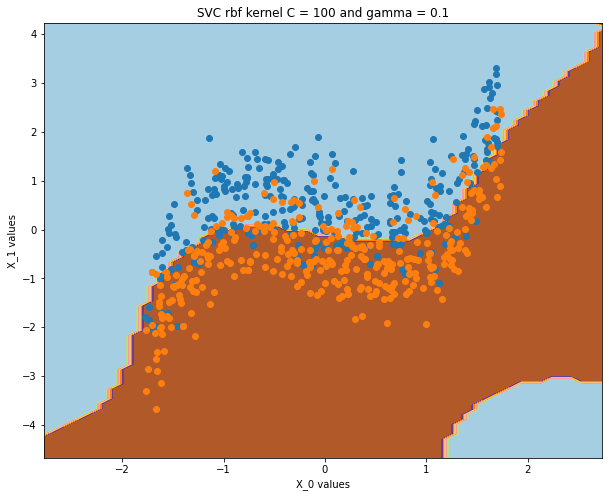

Accuracy score= 0.7643504531722054




In [113]:
clf_2 = svm.SVC(C=100, kernel = 'rbf', gamma = 0.1)
clf_2.fit(X_train_2,y_train_2.ravel())
plt.figure(figsize=(10, 8))
plt.title("SVC rbf kernel C = 100 and gamma = 0.1")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
#plot_margin(X_train,y_train.ravel(),clf_2)
plot_decisions(X_train_2,y_train_2.ravel(),clf_2)
plt.show()
    
y_pred_2 = clf_2.predict(X_test_2) 
# Model Accuracy
accuracy = accuracy_score(y_test_2, y_pred_2)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

Here we can see that GridSearchCV was an exhaustive approach where we got optimized paramters after searching through an entire grid of possible hyper-parameters and which gave a decent accuracy score.

## Using Dataset 3

In [114]:
#Load dataset_3_train.csv and dataset_3_test.csv files

In [115]:
train_data_3 = np.loadtxt("dataset_3_train.csv", delimiter=",")
test_data_3 = np.loadtxt("dataset_3_test.csv", delimiter=",")

In [116]:
# Create X_train y_train X_test y_test

X_train_3 = train_data_3[:,:2]
y_train_3 = train_data_3[:,2:]
X_test_3 = test_data_3[:,:2]
y_test_3 = test_data_3[:,2:]

In [117]:
# Print shape of each data
print(f'X_train shape: {X_train_3.shape}')
print(f'y_train shape: {y_train_3.shape}')
print(f'X_test shape {X_test_3.shape}')
print(f'y_test shape {y_test_3.shape}')

X_train shape: (335, 2)
y_train shape: (335, 1)
X_test shape (165, 2)
y_test shape (165, 1)


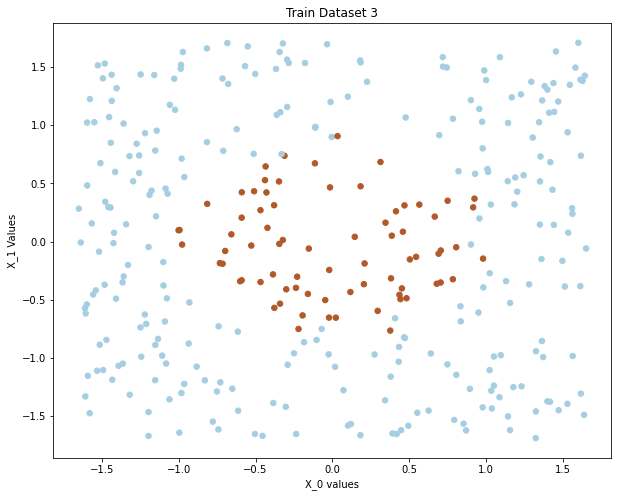

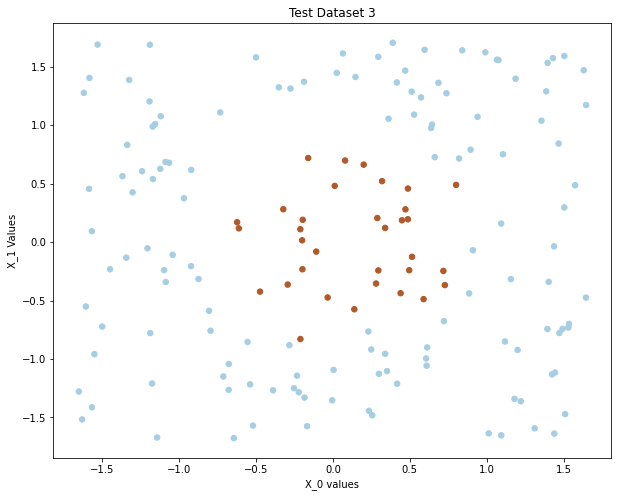

In [118]:
# Plotting the train dataset
plt.figure(figsize=(10, 8))
plt.scatter(X_train_3[:, 0], X_train_3[:, 1], c=y_train_3, s=30, cmap=plt.cm.Paired)
plt.title("Train Dataset 3")
plt.xlabel("X_0 values")
plt.ylabel("X_1 Values")
plt.show()

# Plotting the train dataset
plt.figure(figsize=(10, 8))
plt.scatter(X_test_3[:, 0], X_test_3[:, 1], c=y_test_3, s=30, cmap=plt.cm.Paired)
plt.title("Test Dataset 3")
plt.xlabel("X_0 values")
plt.ylabel("X_1 Values")
plt.show()

### Using GridSearchCV optimizer to find the best hyperparameters for data-set 3

In [147]:
param_grid_3 = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf']}
 
grid_3 = GridSearchCV(svm.SVC(), param_grid_3, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_3.fit(X_train_3, y_train_3.ravel())

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 2/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 3/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 4/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 5/5] END ................C=0.001, gamma=1, kernel=linear; total time=   0.0s
[CV 1/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 2/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 4/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 5/5] END ..................C=0.001, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV 2/5] END ...................C=0.001, gamma=

[CV 2/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 1/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV 2/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV 3/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV 4/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV 5/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV 1/5] END ................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV 2/5] END ................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV 3/5] END ................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV 4/5] END ...............

[CV 4/5] END ................C=10, gamma=0.0001, kernel=poly; total time=   0.0s
[CV 5/5] END ................C=10, gamma=0.0001, kernel=poly; total time=   0.0s
[CV 1/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 1/5] END ..................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV 2/5] END ..................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV 3/5] END ..................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV 4/5] END ..................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV 5/5] END ..................C=100, gamma=1, kernel=linear; total time=   0.0s
[CV 1/5] END ...............

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=3)

In [148]:
# print best parameter after tuning
print("Best Param: ",grid_3.best_params_)
 
# print how our model looks after hyper-parameter tuning
print("Best estimator: ",grid_3.best_estimator_)

grid_predictions_3 = grid_3.predict(X_test_3)

Best Param:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best estimator:  SVC(C=10, gamma=1)


Using above hyper-parameters on SVM and plot the decision boundary

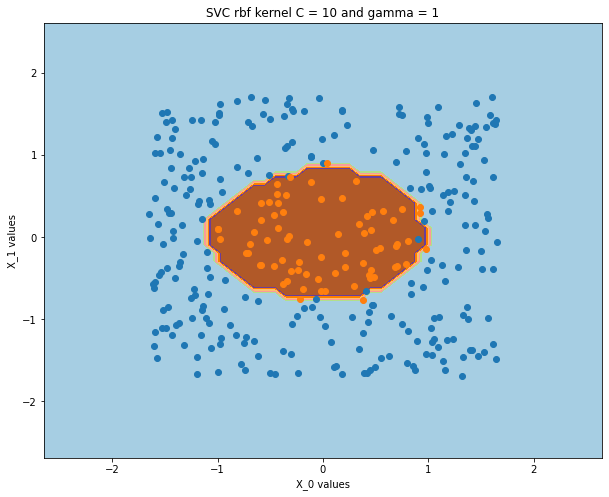

Accuracy score= 0.9575757575757575




In [152]:
clf_3 = svm.SVC(C=10, kernel = 'rbf', gamma = 1)
clf_3.fit(X_train_3,y_train_3.ravel())
plt.figure(figsize=(10, 8))
plt.title("SVC rbf kernel C = 10 and gamma = 1")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
#plot_margin(X_train,y_train.ravel(),clf_2)
plot_decisions(X_train_3,y_train_3.ravel(),clf_3)
plt.show()
    
y_pred_3 = clf_3.predict(X_test_3) 
# Model Accuracy
accuracy = accuracy_score(y_test_3, y_pred_3)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

Using GridSearchCV an exhaustive approach we were able to achieve an accuracy of about 95.75%

### Using BayesSearchCV optimizer to find the best hyperparameters for data-set 3

In [119]:
optSVM1_data_3 = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
      'kernel': Categorical(['linear', 'rbf','poly','sigmoid']),
    },
    n_iter=50,
    random_state=42
)

optSVM1_data_3.fit(X_train_3, y_train_3.ravel())

BayesSearchCV(estimator=SVC(), random_state=42,
              search_spaces={'C': Real(low=0.001, high=1000.0, prior='log-uniform', transform='normalize'),
                             'kernel': Categorical(categories=('linear', 'rbf', 'poly', 'sigmoid'), prior=None)})

In [120]:
print("Best Kernel: ",optSVM1_data_3.best_estimator_.kernel)
print("Best Estimator: ",optSVM1_data_3.best_estimator_)

Best Kernel:  rbf
Best Estimator:  SVC(C=15.410057432542901)


Using optiml paramters from Bayes Search CV for SVC to plot on the dataset-3

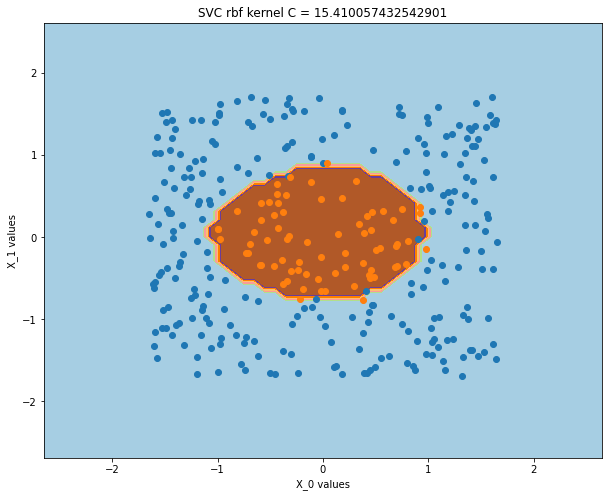

Accuracy score= 0.9696969696969697




In [121]:
clf_3 = svm.SVC(C=15.410057432542901, kernel = 'rbf', gamma = 'auto')
clf_3.fit(X_train_3,y_train_3.ravel())
plt.figure(figsize=(10, 8))
plt.title("SVC rbf kernel C = 15.410057432542901")
plt.xlabel("X_0 values")
plt.ylabel("X_1 values")
#plot_margin(X_train,y_train.ravel(),clf_3)
plot_decisions(X_train_3,y_train_3.ravel(),clf_3)
plt.show()
    
y_pred_3 = clf_3.predict(X_test_3) 
# Model Accuracy
accuracy = accuracy_score(y_test_3, y_pred_3)
print ('Accuracy score= {}'.format(accuracy))
print()
print("="*50)
print()

In [123]:
print("Training Accuracy:", clf_3.score(X_train_3, y_train_3))
print("Test Accuracy:",clf_3.score(X_test_3, y_test_3))

Training Accuracy: 0.9701492537313433
Test Accuracy: 0.9696969696969697


<module 'matplotlib.pyplot' from 'C:\\Users\\jdsam\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

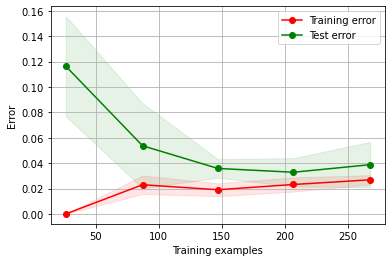

In [139]:
plot_learning_curve(optSVM1_data_3,"Training SVM",X_train_3,y_train_3)

We are able to achieve a test accuracy of about 96.96% using BayesinSearchCV on data-set 3

### Using BayesSearchCV with the MLPWrapper on data-set 3

In [128]:
optNN1_3 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100),
    },
    n_iter=30,
    random_state=42
) 

In [129]:
optNN1_3.fit(X_train_3,y_train_3.ravel())

BayesSearchCV(estimator=MLPWrapper(), n_iter=30, random_state=42,
              search_spaces={'layer1': Integer(low=1, high=100, prior='uniform', transform='normalize'),
                             'layer2': Integer(low=1, high=100, prior='uniform', transform='normalize')})

In [130]:
print("Score: ",optNN1_3.score(X_test_3, y_test_3.ravel()))
print("Best paramter: ",optNN1_3.best_estimator_)

Score:  0.9757575757575757
Best paramter:  MLPWrapper(layer1=62, layer2=78)


Using MLP classifier with the layers obtained from BayesianSearchCV MLP wrapper along with Relu activation function and Adam optimizaion parameters

In [131]:
mlp_clf_3 = MLPClassifier(random_state=42,hidden_layer_sizes=(62,78), 
                          activation = 'relu', solver='adam').fit(X_train_3, y_train_3.ravel())
print("Score: ",mlp_clf_3.score(X_test_3, y_test_3.ravel()))

Score:  0.9757575757575757


In [133]:
print("Best paramter: ",optNN1_3.best_estimator_)

Best paramter:  MLPWrapper(layer1=62, layer2=78)


In [136]:
optNN1_3.score(X_test_3, y_test_3.ravel())

0.9757575757575757

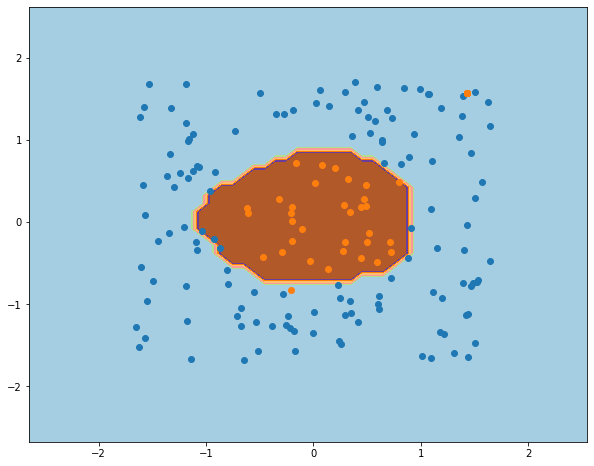

In [137]:
# Plotting decision boundary
plt.figure(figsize=(10, 8))
plot_decisions(X_test_3, y_test_3,optNN1_3)

<module 'matplotlib.pyplot' from 'C:\\Users\\jdsam\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

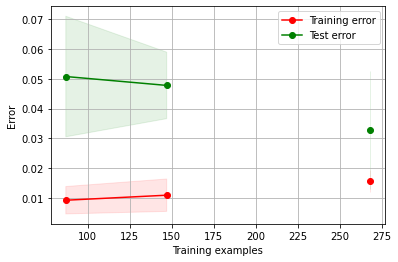

In [140]:
# Plotting the learning curve
plot_learning_curve(optNN1_3,"Training SVM",X_train_3, y_train_3)

## Reflection


Data-set 2 and 3 are non-linear data-sets and using various other hyper-parameters like kernel, gamm and activation function we are able to get a better decision bounday. I used GridSearchCV, BayesSearchCV and MLP(Neural Network) for finding a better hyper-parameter for tuning the SVM. Initially I tried using all the kernels to see how the performance and decision boundary turns out but later as I progressed I was able to identify that BayesSearchCV was the most effective soution and along with MLP classifier I was able to achieve better accuracy.

Below are the results summarised for both the data-sets

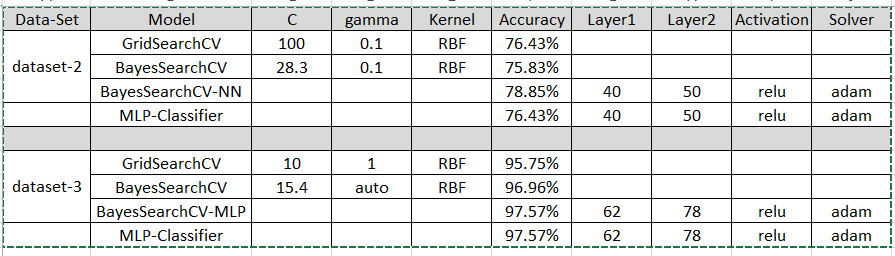

From above table we could see that both the models (GridSearchCV and BayesSearchCV) performed well for classifying the data but the Neural Network has an edge which helps in improving the accuracy score a little bit.

Also, all the learning curve for both the models and datasets shows that in-sample and out-sample errors are decreasing with minimal gap.